# Daily iOS Screen Time Patterns and Their Relationship to Social-Media Usage

**Course:** CCDATSCL Data Science  

The dataset consists of 81 daily records for approx. 12 weeks (November 19, 2025 to February 7, 2026) collected from a single participant using Apple iOS Screen Time and self-reported goal-violation data. Each row represents one full day and includes nine variables that capture different aspects of digital behavior. These variables are: total screen time (all apps), social media app usage time, social intensity ratio (proportion of screen time spent on social apps), total device pickups, first pickups focused on social apps, total notifications received, notifications from social apps, the number of distinct social apps used, and a binary indicator of whether the participant exceeded their intended social media usage for that day. All metrics, except for social intensity ratio and goal-violation, are objectively recorded by the device, providing an accurate and detailed view of daily smartphone and social media habits. The dataset enables analysis of how specific digital behaviors relate to self-regulation and goal-violation over time.

# Variable Summary

| # | Variable Name | Type | Unit | Description |
|---|---|---|---|---|
| 1 | Total screen time IN MINUTES (all apps) | Numeric (Continuous) | Minutes | Total daily screen time across all apps on the device |
| 2 | Social apps total time IN MINUTES | Numeric (Continuous) | Minutes | Time spent on social media apps only |
| 3 | Social Intensity Ratio | Numeric (Continuous) | Ratio | Proportion of total screen time spent on social apps calculated using Social Apps Total Time ÷ Total Screen Time |
| 4 | Pickups (total) | Numeric (Discrete) | Count | Total number of times the device was picked up |
| 5 | First Pickups (social apps) | Numeric (Discrete) | Count | Number of times the device was first unlocked with social app focus |
| 6 | Notifications (total) | Numeric (Discrete) | Count | Total daily notifications received |
| 7 | Notifications (social) | Numeric (Discrete) | Count | Notifications from social media apps only |
| 8 | Number of distinct social apps used | Numeric (Discrete) | Count | Number of unique/different social apps used that day |
| 9 | Daily goal-violation | Categorical (Binary) | 0 or 1 | Self-reported goal-violation (1=Yes, exceeded intended time; 0=No, Response to: “Did I spend more time on social media than I intended today?”) |

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

### Data Loading

In [18]:
url = "https://raw.githubusercontent.com/ellaangela/CCDATSCL_PROJECT_COM222/refs/heads/main/dataset%20compiled.csv"

df_data = pd.read_csv(url)
print(df_data)

    Total screen time IN MINUTES (all apps)  \
0                                       589   
1                                       511   
2                                       607   
3                                       715   
4                                       499   
..                                      ...   
76                                      446   
77                                      513   
78                                      515   
79                                      223   
80                                      416   

    Social apps total time IN MINUTES  Social Intensity Ratio  \
0                                 479                0.813243   
1                                 408                0.798434   
2                                 505                0.831960   
3                                 560                0.783217   
4                                 399                0.799599   
..                                ...        

In [19]:
print("First 5 rows of df_data:")
print(df_data.head())

print("\nDataFrame Info:")
df_data.info()

print("\nDescriptive Statistics:")
print(df_data.describe())

print("\nShape of the DataFrame:")
print(df_data.shape)

First 5 rows of df_data:
   Total screen time IN MINUTES (all apps)  Social apps total time IN MINUTES  \
0                                      589                                479   
1                                      511                                408   
2                                      607                                505   
3                                      715                                560   
4                                      499                                399   

   Social Intensity Ratio  Pickups (total)  First Pickups (social apps)  \
0                0.813243              114                           53   
1                0.798434              135                           81   
2                0.831960              132                           76   
3                0.783217              135                           87   
4                0.799599               85                           38   

   Notifications (total)  Notificatio

In [20]:
print("Column Names:")
print(df_data.columns.tolist())
print("\nData Types:")
print(df_data.dtypes)
print("\nDate Range:")
if 'Date' in df_data.columns:
    print(f"From {df_data['Date'].min()} to {df_data['Date'].max()}")

Column Names:
['Total screen time IN MINUTES (all apps)', 'Social apps total time IN MINUTES', 'Social Intensity Ratio', 'Pickups (total)', 'First Pickups (social apps)', 'Notifications (total)', 'Notifications (social)', 'Number of distinct social apps used', 'Daily goal-violation']

Data Types:
Total screen time IN MINUTES (all apps)      int64
Social apps total time IN MINUTES            int64
Social Intensity Ratio                     float64
Pickups (total)                              int64
First Pickups (social apps)                  int64
Notifications (total)                        int64
Notifications (social)                       int64
Number of distinct social apps used          int64
Daily goal-violation                         int64
dtype: object

Date Range:


### Data Cleaning

In [21]:
print("DATA CLEANING REPORT")
print("=" * 60)

print("\n1. MISSING VALUES CHECK")
print("-" * 60)
missing_counts = df_data.isnull().sum()
if missing_counts.sum() == 0:
    print("✓ No missing values found")
else:
    print(missing_counts[missing_counts > 0])

print("\n2. DUPLICATE CHECK")
print("-" * 60)
n_duplicates = df_data.duplicated().sum()
if n_duplicates == 0:
    print("✓ No duplicate rows found")
else:
    print(f"Found {n_duplicates} duplicate rows")
    df_data = df_data.drop_duplicates()

print("\n3. DATA TYPE CHECK")
print("-" * 60)
print(df_data.dtypes)

# Check for outliers using IQR method
print("\n4. OUTLIER DETECTION (IQR Method)")
print("-" * 60)

def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

numeric_cols = df_data.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col != 'Daily goal-violation':  # Exclude the target variable
        n_outliers, lower, upper = identify_outliers(df_data, col)
        if n_outliers > 0:
            print(f"{col}: {n_outliers} outliers (bounds: {lower:.2f} - {upper:.2f})")
        else:
            print(f"{col}: No outliers detected")

print("\n" + "=" * 60)
print("CLEANING COMPLETED")
print(f"Dataset shape: {df_data.shape}")
print(f"Columns: {df_data.columns.tolist()}")

DATA CLEANING REPORT

1. MISSING VALUES CHECK
------------------------------------------------------------
✓ No missing values found

2. DUPLICATE CHECK
------------------------------------------------------------
✓ No duplicate rows found

3. DATA TYPE CHECK
------------------------------------------------------------
Total screen time IN MINUTES (all apps)      int64
Social apps total time IN MINUTES            int64
Social Intensity Ratio                     float64
Pickups (total)                              int64
First Pickups (social apps)                  int64
Notifications (total)                        int64
Notifications (social)                       int64
Number of distinct social apps used          int64
Daily goal-violation                         int64
dtype: object

4. OUTLIER DETECTION (IQR Method)
------------------------------------------------------------
Total screen time IN MINUTES (all apps): 3 outliers (bounds: 260.00 - 804.00)
Social apps total time IN MINUTE


### Descriptive Statistics

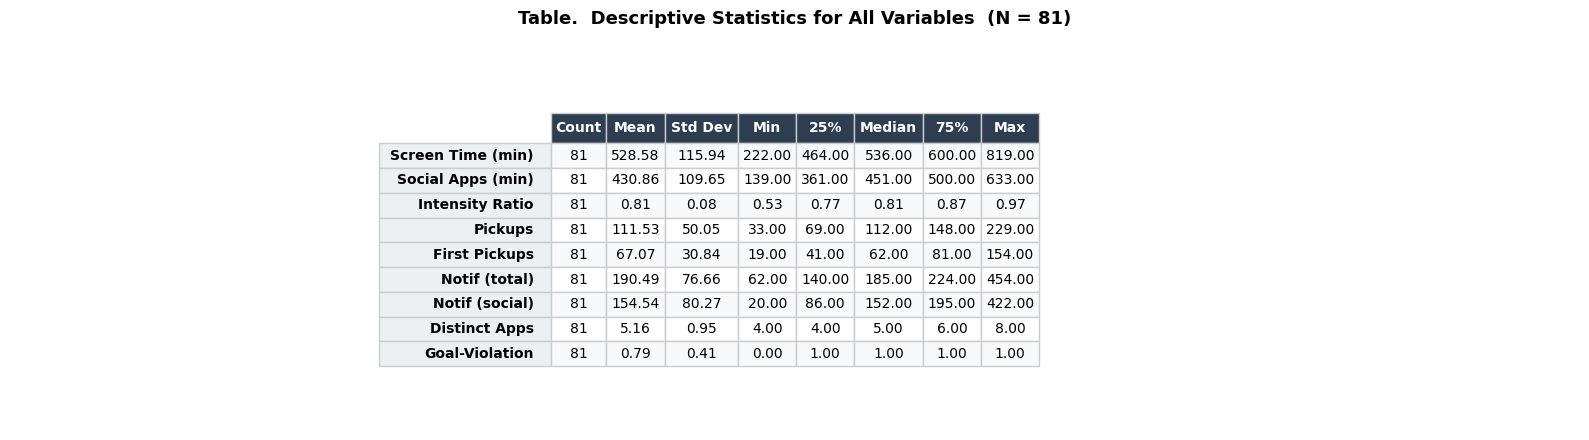


Target Variable Distribution:
  Goal-Violation (1):  64 days  (79.0%)
  Non-Violation (0):   17 days  (21.0%)
  Total:               81 days


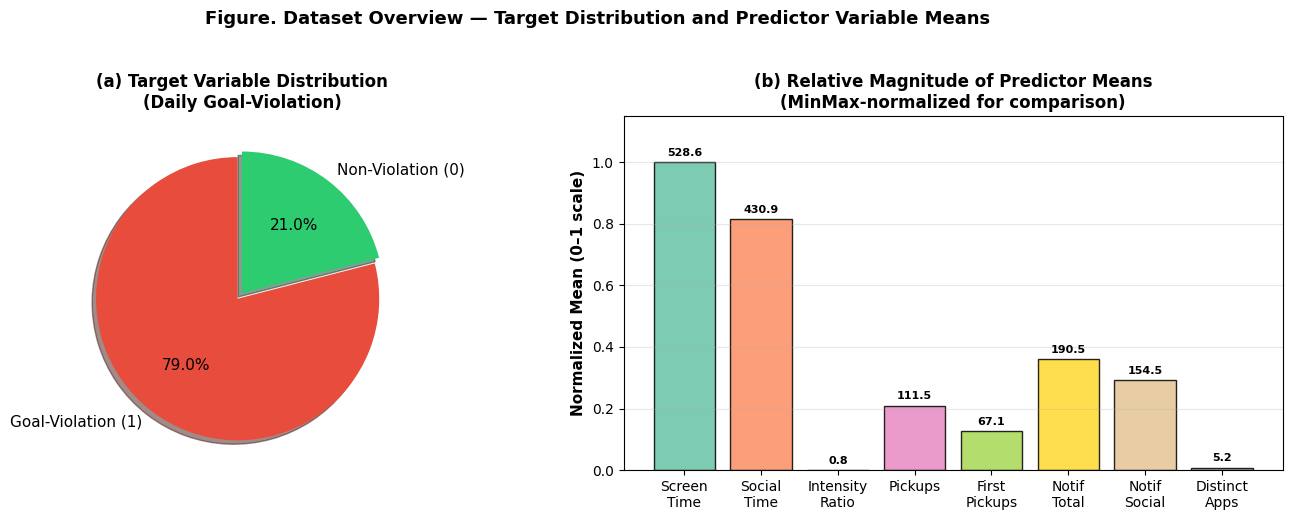

In [22]:
independent_vars = [
    'Total screen time IN MINUTES (all apps)',
    'Social apps total time IN MINUTES',
    'Social Intensity Ratio',
    'Pickups (total)',
    'First Pickups (social apps)',
    'Notifications (total)',
    'Notifications (social)',
    'Number of distinct social apps used'
]

# Short variable names for display
short_names = [
    'Screen Time (min)',
    'Social Apps (min)',
    'Intensity Ratio',
    'Pickups',
    'First Pickups',
    'Notif (total)',
    'Notif (social)',
    'Distinct Apps',
]

desc_stats = df_data.describe().T
desc_stats.columns = ['Count', 'Mean', 'Std Dev', 'Min', '25%', 'Median', '75%', 'Max']

short_names_all = short_names + ['Goal-Violation']
desc_stats.index = short_names_all

table_data = []
for _, row in desc_stats.iterrows():
    table_data.append([f'{int(row["Count"])}'] + [f'{v:.2f}' for v in row[1:]])

fig_t, ax_t = plt.subplots(figsize=(16, 4.5))
ax_t.axis('off')
tbl = ax_t.table(cellText=table_data,
                 colLabels=desc_stats.columns.tolist(),
                 rowLabels=desc_stats.index.tolist(),
                 cellLoc='center', rowLoc='right', loc='center')

for (r, c), cell in tbl.get_celld().items():
    cell.set_edgecolor('#cccccc')
    cell.set_fontsize(10)
    if r == 0:                       
        cell.set_facecolor('#2c3e50')
        cell.set_text_props(color='white', fontweight='bold', fontsize=10)
        cell.set_height(0.08)
    elif c == -1:                    
        cell.set_facecolor('#ecf0f1')
        cell.set_text_props(fontweight='bold', fontsize=9)
        cell.set_height(0.065)
    else:
        cell.set_facecolor('#ffffff' if r % 2 == 0 else '#f7f9fa')
        cell.set_height(0.065)

tbl.auto_set_column_width(list(range(len(desc_stats.columns))))
ax_t.set_title('Table.  Descriptive Statistics for All Variables  (N = 81)',
               fontsize=13, fontweight='bold', pad=18)
plt.tight_layout()
plt.show()

counts = df_data['Daily goal-violation'].value_counts()
print(f"\nTarget Variable Distribution:")
print(f"  Goal-Violation (1):  {counts[1]} days  ({counts[1]/len(df_data)*100:.1f}%)")
print(f"  Non-Violation (0):   {counts[0]} days  ({counts[0]/len(df_data)*100:.1f}%)")
print(f"  Total:               {len(df_data)} days")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

labels = ['Goal-Violation (1)', 'Non-Violation (0)']
sizes = [counts[1], counts[0]]
colors_pie = ['#e74c3c', '#2ecc71']
explode = (0.05, 0)
axes[0].pie(sizes, explode=explode, labels=labels, colors=colors_pie, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 11})
axes[0].set_title('(a) Target Variable Distribution\n(Daily Goal-Violation)', fontsize=12, fontweight='bold')

short_labels = ['Screen\nTime', 'Social\nTime', 'Intensity\nRatio', 'Pickups', 
                'First\nPickups', 'Notif\nTotal', 'Notif\nSocial', 'Distinct\nApps']
means = [df_data[v].mean() for v in independent_vars]
from sklearn.preprocessing import MinMaxScaler
means_norm = MinMaxScaler().fit_transform(np.array(means).reshape(-1, 1)).flatten()
bar_colors = plt.cm.Set2(np.linspace(0, 1, 8))
axes[1].bar(short_labels, means_norm, color=bar_colors, edgecolor='black', alpha=0.85)
axes[1].set_ylabel('Normalized Mean (0–1 scale)', fontsize=11, fontweight='bold')
axes[1].set_title('(b) Relative Magnitude of Predictor Means\n(MinMax-normalized for comparison)', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 1.15)
for i, v in enumerate(means_norm):
    axes[1].text(i, v + 0.02, f'{means[i]:.1f}', ha='center', fontsize=8, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('Figure. Dataset Overview — Target Distribution and Predictor Variable Means',
             fontsize=13, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

### Distribution of Variables

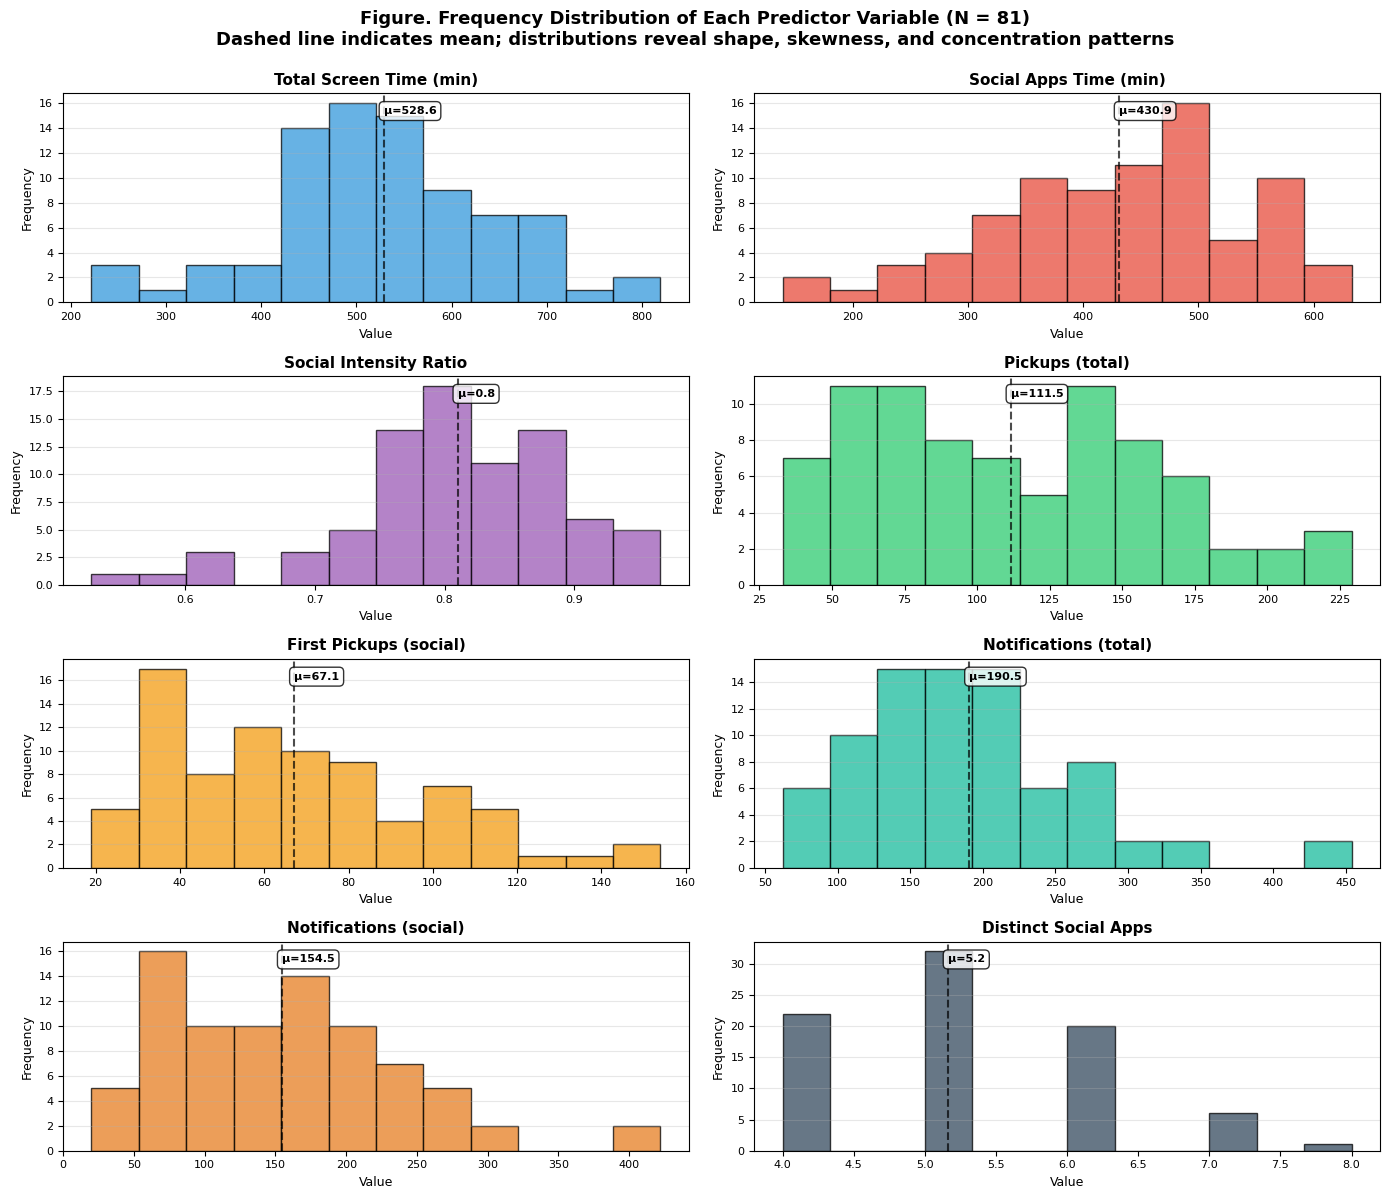

In [23]:
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
axes = axes.flatten()

hist_config = [
    ('Total screen time IN MINUTES (all apps)', 'Total Screen Time (min)', '#3498db'),
    ('Social apps total time IN MINUTES', 'Social Apps Time (min)', '#e74c3c'),
    ('Social Intensity Ratio', 'Social Intensity Ratio', '#9b59b6'),
    ('Pickups (total)', 'Pickups (total)', '#2ecc71'),
    ('First Pickups (social apps)', 'First Pickups (social)', '#f39c12'),
    ('Notifications (total)', 'Notifications (total)', '#1abc9c'),
    ('Notifications (social)', 'Notifications (social)', '#e67e22'),
    ('Number of distinct social apps used', 'Distinct Social Apps', '#34495e'),
]

for idx, (col_name, label, color) in enumerate(hist_config):
    ax = axes[idx]
    ax.hist(df_data[col_name], bins=12, color=color, edgecolor='black', alpha=0.75)
    ax.set_title(label, fontsize=11, fontweight='bold')
    ax.set_xlabel('Value', fontsize=9)
    ax.set_ylabel('Frequency', fontsize=9)
    ax.tick_params(labelsize=8)
    ax.grid(axis='y', alpha=0.3)
    
    mean_val = df_data[col_name].mean()
    ax.axvline(mean_val, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.text(mean_val, ax.get_ylim()[1] * 0.90, f'μ={mean_val:.1f}', 
            fontsize=8, ha='left', fontweight='bold', 
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='black'))

plt.suptitle('Figure. Frequency Distribution of Each Predictor Variable (N = 81)\nDashed line indicates mean; distributions reveal shape, skewness, and concentration patterns',
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### Group Comparisons (Goal-Violation vs. Non-Violation)

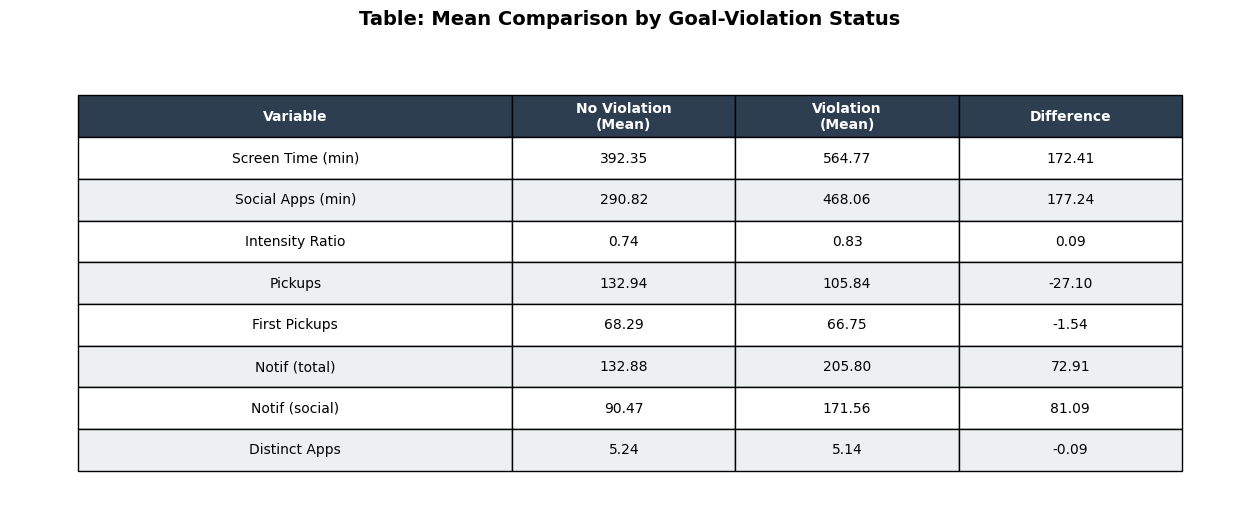


Table: Group Comparison
                               Variable  No Violation (Mean)  Violation (Mean)  Difference
Total screen time IN MINUTES (all apps)           392.352941        564.765625  172.412684
      Social apps total time IN MINUTES           290.823529        468.062500  177.238971
                 Social Intensity Ratio             0.738297          0.829042    0.090744
                        Pickups (total)           132.941176        105.843750  -27.097426
            First Pickups (social apps)            68.294118         66.750000   -1.544118
                  Notifications (total)           132.882353        205.796875   72.914522
                 Notifications (social)            90.470588        171.562500   81.091912
    Number of distinct social apps used             5.235294          5.140625   -0.094669


In [24]:
mask_0 = df_data['Daily goal-violation'] == 0
mask_1 = df_data['Daily goal-violation'] == 1

goal_violation_0 = df_data[mask_0]
goal_violation_1 = df_data[mask_1]

comparison_data = []
for var in independent_vars:
    comparison_data.append({
        'Variable': var,
        'No Violation (Mean)': goal_violation_0[var].mean(),
        'Violation (Mean)': goal_violation_1[var].mean(),
        'Difference': goal_violation_1[var].mean() - goal_violation_0[var].mean()
    })

comparison_df = pd.DataFrame(comparison_data)

fig_t2, ax_t2 = plt.subplots(figsize=(16, 6))
ax_t2.axis('tight')
ax_t2.axis('off')

table_data2 = [['Variable', 'No Violation\n(Mean)', 'Violation\n(Mean)', 'Difference']]
for i, row in comparison_df.iterrows():
    table_data2.append([
        short_names[i],
        f"{row['No Violation (Mean)']:.2f}",
        f"{row['Violation (Mean)']:.2f}",
        f"{row['Difference']:.2f}"
    ])

tbl2 = ax_t2.table(cellText=table_data2, cellLoc='center', loc='center',
                   colWidths=[0.35, 0.18, 0.18, 0.18])
tbl2.auto_set_font_size(False)
tbl2.set_fontsize(10)
tbl2.scale(1, 2.5)

for j in range(4):
    cell = tbl2[(0, j)]
    cell.set_facecolor('#2c3e50')
    cell.set_text_props(weight='bold', color='white')

for i in range(1, len(table_data2)):
    for j in range(4):
        cell = tbl2[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#ecf0f1')
        else:
            cell.set_facecolor('#ffffff')

plt.title('Table: Mean Comparison by Goal-Violation Status', 
          fontsize=14, fontweight='bold', pad=20)
plt.show()

print("\nTable: Group Comparison")
print(comparison_df.to_string(index=False))

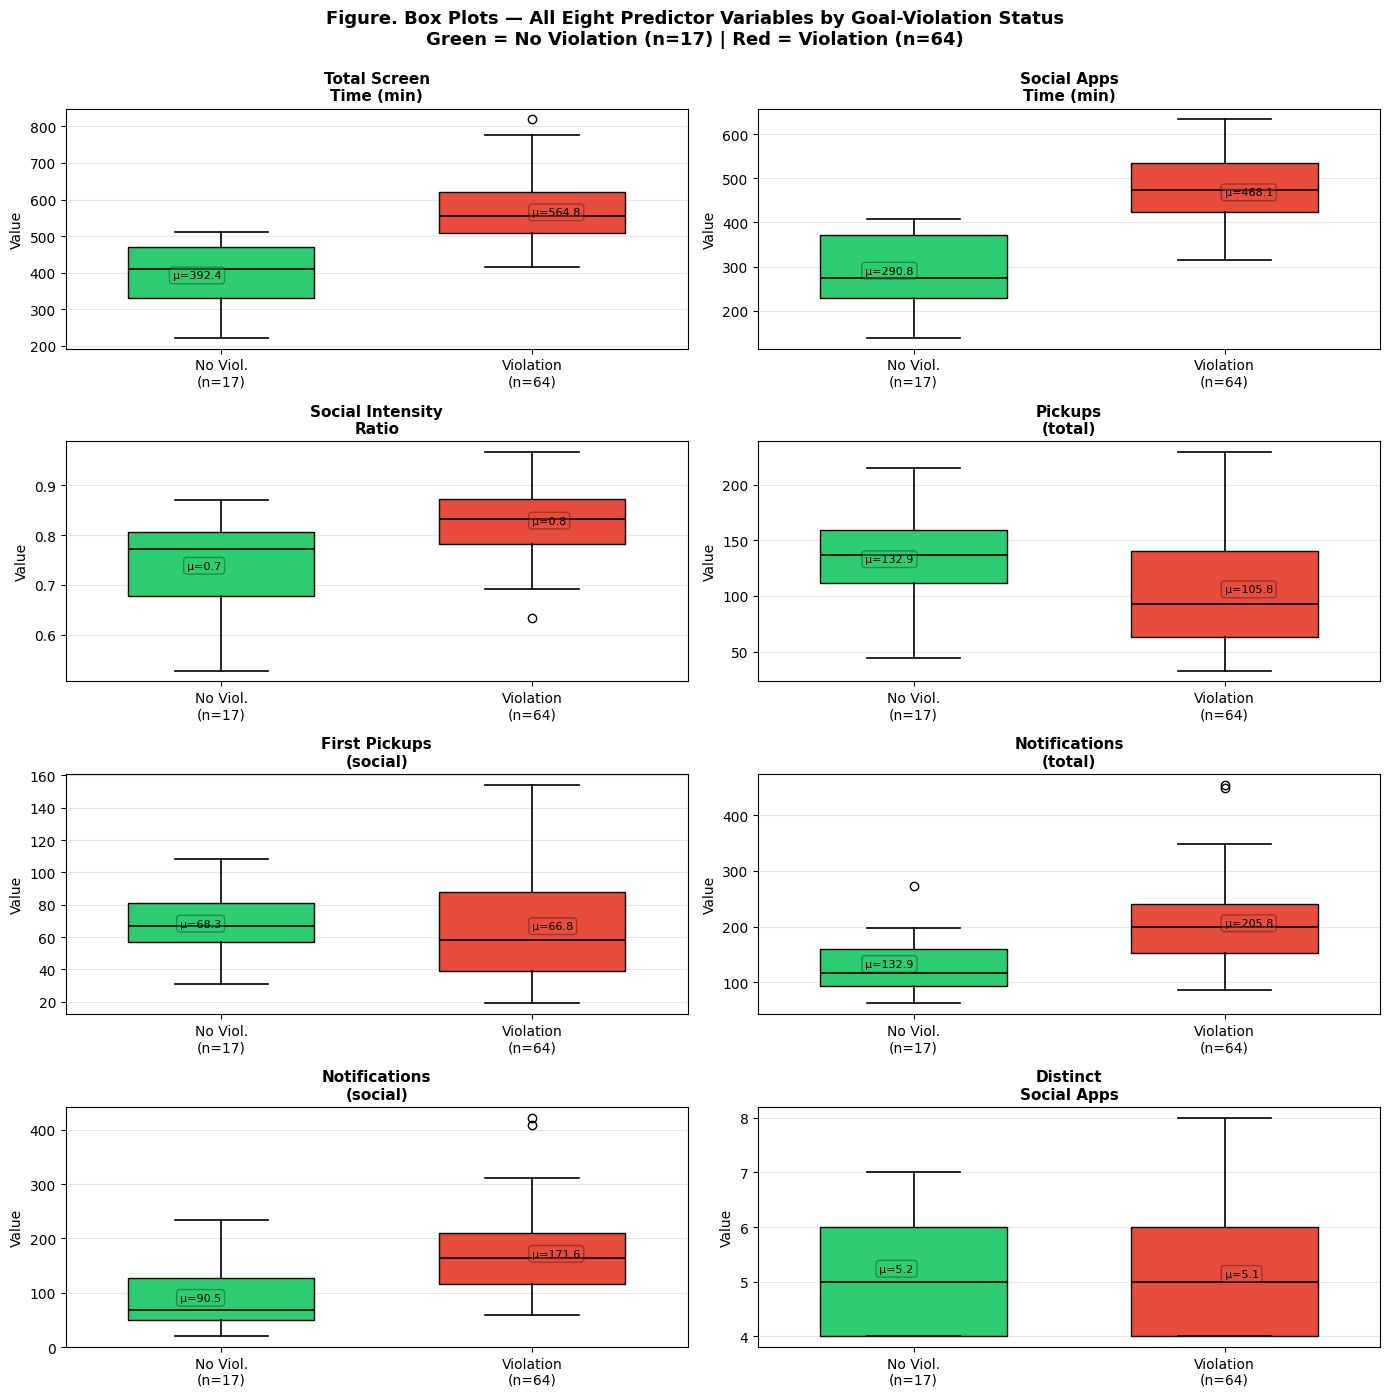

In [25]:
fig, axes = plt.subplots(4, 2, figsize=(14, 14))

short_titles = ['Total Screen\nTime (min)', 'Social Apps\nTime (min)', 'Social Intensity\nRatio', 
                'Pickups\n(total)', 'First Pickups\n(social)', 'Notifications\n(total)', 
                'Notifications\n(social)', 'Distinct\nSocial Apps']

for idx, (var, title) in enumerate(zip(independent_vars, short_titles)):
    row, col = divmod(idx, 2)
    ax = axes[row, col]
    data_groups = [goal_violation_0[var], goal_violation_1[var]]
    bp = ax.boxplot(data_groups, tick_labels=['No Viol.\n(n=17)', 'Violation\n(n=64)'], 
                    patch_artist=True, widths=0.6)
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')
    
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', linewidth=1.2)
    
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_ylabel('Value', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    mean_0 = goal_violation_0[var].mean()
    mean_1 = goal_violation_1[var].mean()
    ax.text(1, mean_0, f'μ={mean_0:.1f}', fontsize=8, ha='right', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#2ecc71', alpha=0.3))
    ax.text(2, mean_1, f'μ={mean_1:.1f}', fontsize=8, ha='left', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#e74c3c', alpha=0.3))

plt.suptitle('Figure. Box Plots — All Eight Predictor Variables by Goal-Violation Status\n'
             'Green = No Violation (n=17) | Red = Violation (n=64)',
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### Time-Series Patterns

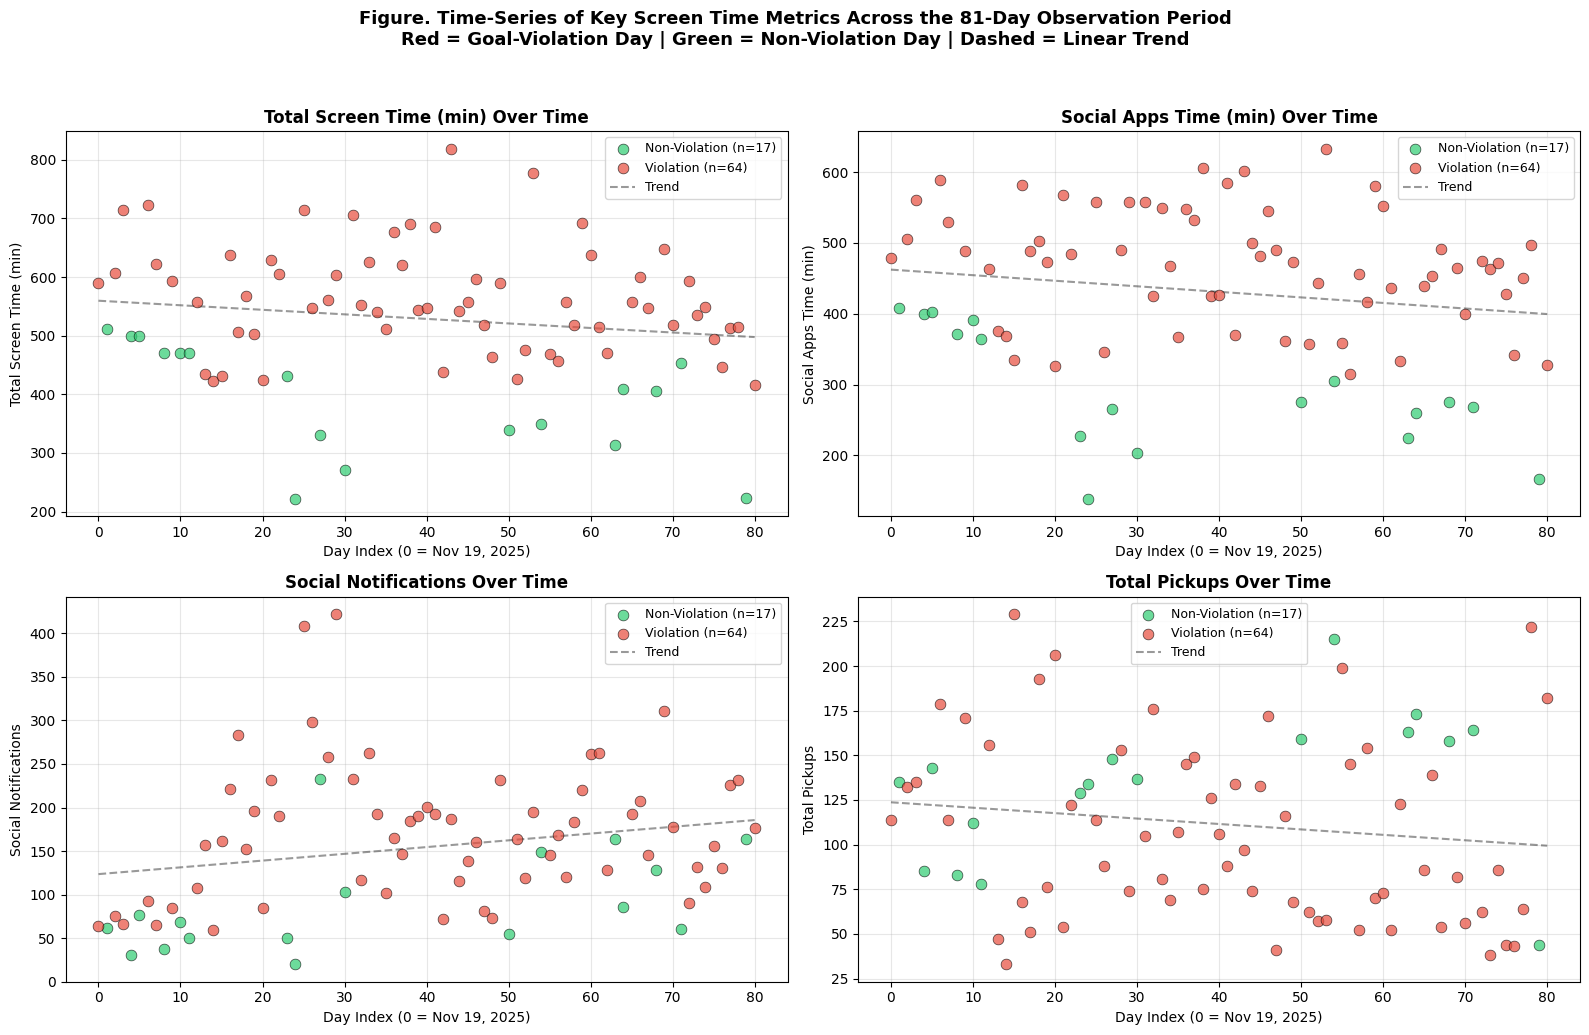

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

time_metrics = [
    ('Total screen time IN MINUTES (all apps)', 'Total Screen Time (min)'),
    ('Social apps total time IN MINUTES', 'Social Apps Time (min)'),
    ('Notifications (social)', 'Social Notifications'),
    ('Pickups (total)', 'Total Pickups')
]

mask_0 = df_data['Daily goal-violation'] == 0
mask_1 = df_data['Daily goal-violation'] == 1

for idx, (var, label) in enumerate(time_metrics):
    row, col = divmod(idx, 2)
    ax = axes[row, col]
    ax.scatter(df_data.index[mask_0], df_data.loc[mask_0, var], c='#2ecc71', alpha=0.7, s=60, 
               label=f'Non-Violation (n={mask_0.sum()})', edgecolors='black', linewidth=0.5, zorder=3)
    ax.scatter(df_data.index[mask_1], df_data.loc[mask_1, var], c='#e74c3c', alpha=0.7, s=60, 
               label=f'Violation (n={mask_1.sum()})', edgecolors='black', linewidth=0.5, zorder=3)
    
    z = np.polyfit(df_data.index, df_data[var], 1)
    p = np.poly1d(z)
    ax.plot(df_data.index, p(df_data.index), 'k--', alpha=0.4, linewidth=1.5, label='Trend')
    
    ax.set_title(f'{label} Over Time', fontsize=12, fontweight='bold')
    ax.set_xlabel('Day Index (0 = Nov 19, 2025)', fontsize=10)
    ax.set_ylabel(label, fontsize=10)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Figure. Time-Series of Key Screen Time Metrics Across the 81-Day Observation Period\n'
             'Red = Goal-Violation Day | Green = Non-Violation Day | Dashed = Linear Trend',
             fontsize=13, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

displays temporal patterns for the four metrics with the largest group differences. Red points (violation days) tend to cluster at higher values for time-based and notification-based metrics, while blue points (non-violation days) show higher pickup counts. The trend lines reveal relatively stable patterns across the observation period.

### Correlation Analysis

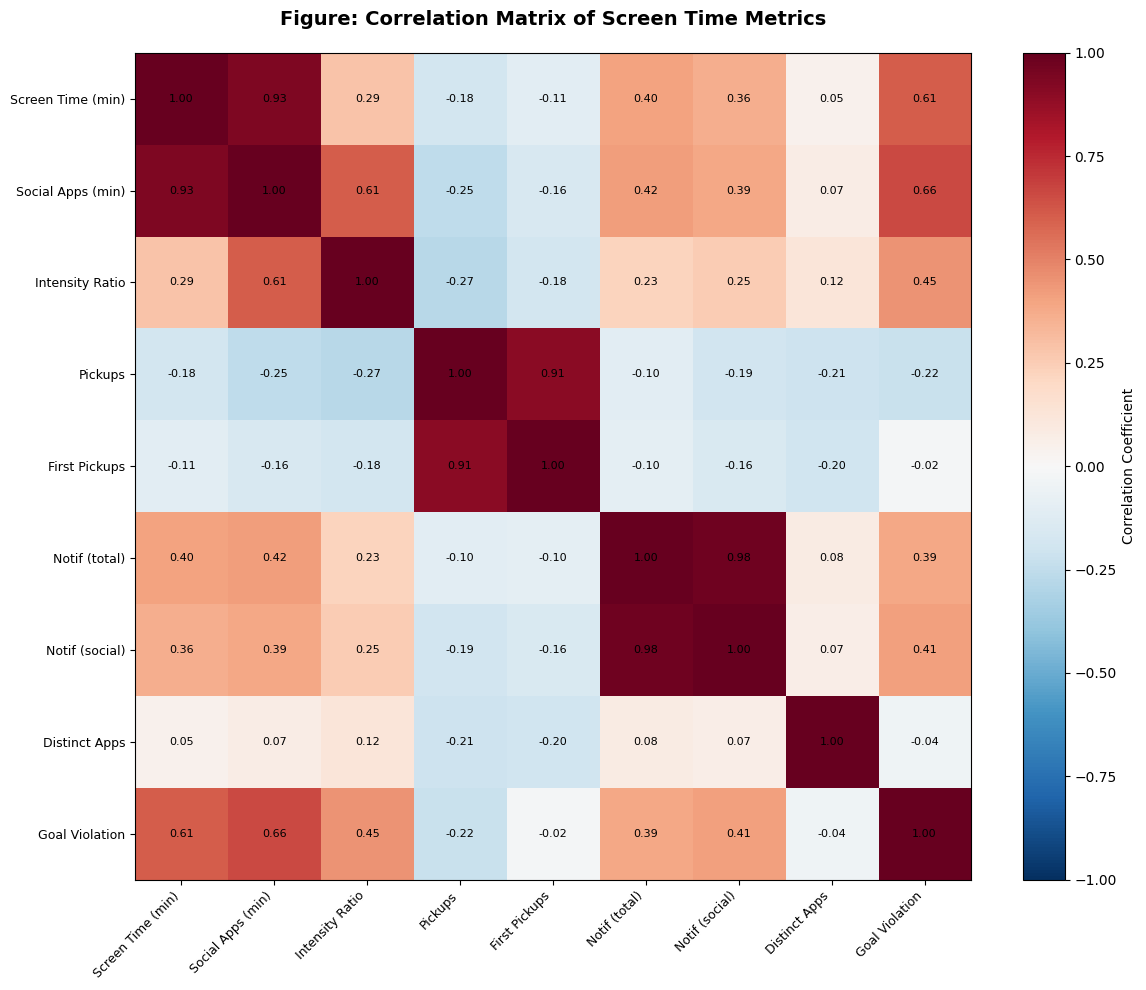


Correlations with Daily goal-violation (sorted by magnitude):
Social apps total time IN MINUTES          0.662342
Total screen time IN MINUTES (all apps)    0.609332
Social Intensity Ratio                     0.447915
Notifications (social)                     0.413972
Notifications (total)                      0.389744
Pickups (total)                           -0.221840
Number of distinct social apps used       -0.040633
First Pickups (social apps)               -0.020517
Name: Daily goal-violation, dtype: float64


In [27]:

all_vars = independent_vars + ['Daily goal-violation']
corr_matrix = df_data[all_vars].corr()

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

short_labels_all = short_names + ['Goal Violation']
ax.set_xticks(np.arange(len(short_labels_all)))
ax.set_yticks(np.arange(len(short_labels_all)))
ax.set_xticklabels(short_labels_all, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(short_labels_all, fontsize=9)

for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                      ha='center', va='center', color='black', fontsize=8)

plt.colorbar(im, ax=ax, label='Correlation Coefficient')
plt.title('Figure: Correlation Matrix of Screen Time Metrics', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelations with Daily goal-violation (sorted by magnitude):")
goal_corr = corr_matrix['Daily goal-violation'].drop('Daily goal-violation').sort_values(key=abs, ascending=False)
print(goal_corr)

### Statistical Significance Testing

INDEPENDENT SAMPLES t-TEST (Welch's) WITH EFFECT SIZES


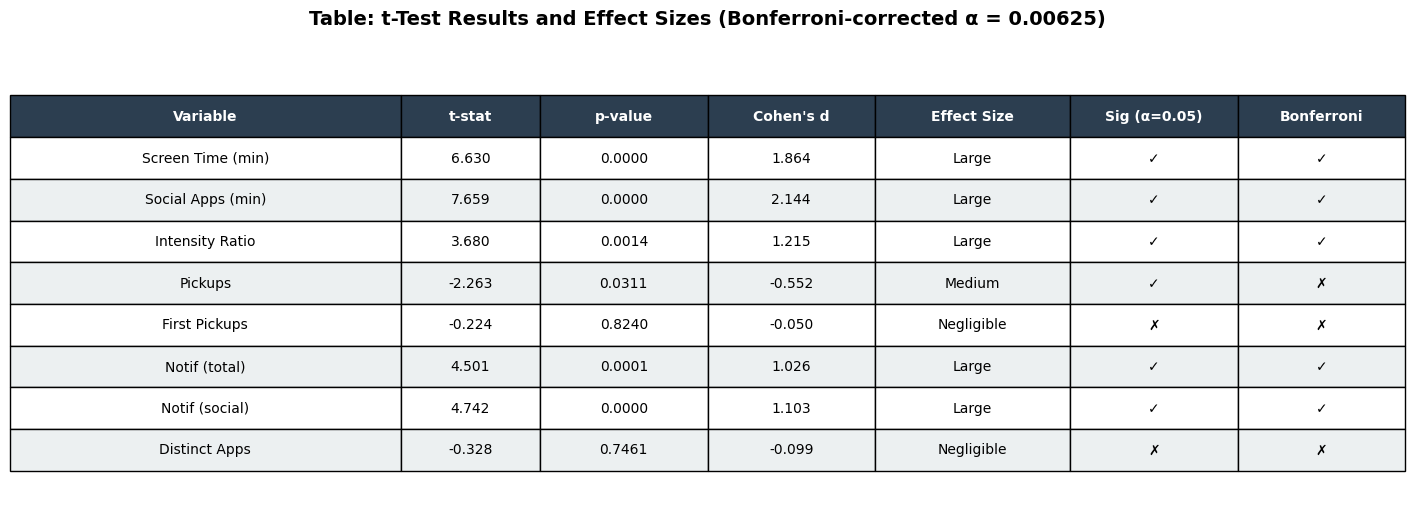


Table: t-Test Results
                               Variable  t-statistic      p-value  Cohen's d Effect Size Sig (α=0.05) Bonferroni
Total screen time IN MINUTES (all apps)     6.630421 7.011820e-07   1.863671       Large            ✓          ✓
      Social apps total time IN MINUTES     7.658673 6.111026e-08   2.144000       Large            ✓          ✓
                 Social Intensity Ratio     3.679907 1.429960e-03   1.214962       Large            ✓          ✓
                        Pickups (total)    -2.262925 3.109012e-02  -0.551747      Medium            ✓          ✗
            First Pickups (social apps)    -0.224074 8.239815e-01  -0.049767  Negligible            ✗          ✗
                  Notifications (total)     4.501039 7.657001e-05   1.026356       Large            ✓          ✓
                 Notifications (social)     4.741587 4.085755e-05   1.102893       Large            ✓          ✓
    Number of distinct social apps used    -0.327820 7.460843e-01  -0.098

In [28]:
print("INDEPENDENT SAMPLES t-TEST (Welch's) WITH EFFECT SIZES")
print("=" * 80)

group_0 = df_data[df_data['Daily goal-violation'] == 0]
group_1 = df_data[df_data['Daily goal-violation'] == 1]

alpha = 0.05
bonferroni_alpha = alpha / len(independent_vars)

ttest_results = []

for var in independent_vars:
    t_stat, p_value = ttest_ind(group_1[var], group_0[var], equal_var=False)
    
    mean_1 = group_1[var].mean()
    mean_0 = group_0[var].mean()
    std_1 = group_1[var].std()
    std_0 = group_0[var].std()
    n_1 = len(group_1)
    n_0 = len(group_0)
    
    pooled_std = np.sqrt(((n_1 - 1) * std_1**2 + (n_0 - 1) * std_0**2) / (n_1 + n_0 - 2))
    d = (mean_1 - mean_0) / pooled_std
    
    abs_d = abs(d)
    if abs_d < 0.2:
        effect = 'Negligible'
    elif abs_d < 0.5:
        effect = 'Small'
    elif abs_d < 0.8:
        effect = 'Medium'
    else:
        effect = 'Large'
    
    sig = '✓' if p_value < alpha else '✗'
    bonf_sig = '✓' if p_value < bonferroni_alpha else '✗'
    
    ttest_results.append({
        'Variable': var,
        't-statistic': t_stat,
        'p-value': p_value,
        "Cohen's d": d,
        'Effect Size': effect,
        'Sig (α=0.05)': sig,
        'Bonferroni': bonf_sig
    })

ttest_df = pd.DataFrame(ttest_results)

fig_t3, ax_t3 = plt.subplots(figsize=(18, 6))
ax_t3.axis('tight')
ax_t3.axis('off')

table_data3 = [['Variable', 't-stat', 'p-value', "Cohen's d", 'Effect Size', 'Sig (α=0.05)', 'Bonferroni']]
for i, row in ttest_df.iterrows():
    table_data3.append([
        short_names[i],
        f"{row['t-statistic']:.3f}",
        f"{row['p-value']:.4f}",
        f"{row['Cohen\'s d']:.3f}",
        row['Effect Size'],
        row['Sig (α=0.05)'],
        row['Bonferroni']
    ])

tbl3 = ax_t3.table(cellText=table_data3, cellLoc='center', loc='center',
                   colWidths=[0.28, 0.10, 0.12, 0.12, 0.14, 0.12, 0.12])
tbl3.auto_set_font_size(False)
tbl3.set_fontsize(10)
tbl3.scale(1, 2.5)

for j in range(7):
    cell = tbl3[(0, j)]
    cell.set_facecolor('#2c3e50')
    cell.set_text_props(weight='bold', color='white')

for i in range(1, len(table_data3)):
    for j in range(7):
        cell = tbl3[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#ecf0f1')
        else:
            cell.set_facecolor('#ffffff')

plt.title('Table: t-Test Results and Effect Sizes (Bonferroni-corrected α = 0.00625)', 
          fontsize=14, fontweight='bold', pad=20)
plt.show()

print("\nTable: t-Test Results")
print(ttest_df.to_string(index=False))
print(f"\nBonferroni-corrected α = {bonferroni_alpha:.5f}")
print(f"Significant at α=0.05: {(ttest_df['Sig (α=0.05)'] == '✓').sum()}/{len(independent_vars)}")
print(f"Significant after Bonferroni correction: {(ttest_df['Bonferroni'] == '✓').sum()}/{len(independent_vars)}")

### Logistic Regression Classification

To determine whether screen time metrics can predict goal-violation in a multivariate framework, a logistic regression model was trained using an 80/20 stratified train-test split with standardized features.

LOGISTIC REGRESSION RESULTS
Training Accuracy: 92.19%
Test Accuracy: 100.00%

Training set size: 64 observations
Test set size: 17 observations


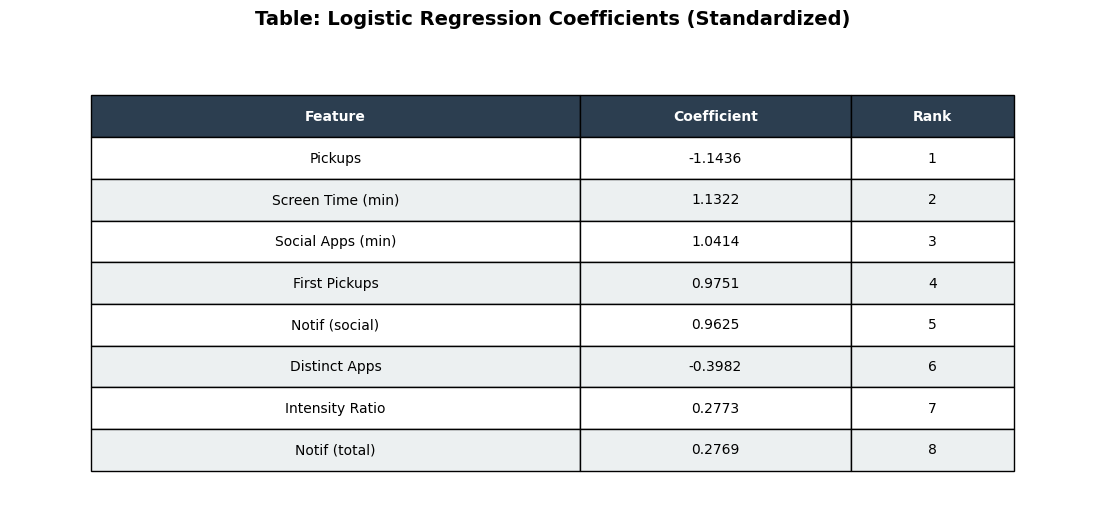


Table: Feature Coefficients (sorted by absolute magnitude)
                                Feature  Coefficient
                        Pickups (total)    -1.143575
Total screen time IN MINUTES (all apps)     1.132190
      Social apps total time IN MINUTES     1.041383
            First Pickups (social apps)     0.975147
                 Notifications (social)     0.962475
    Number of distinct social apps used    -0.398232
                 Social Intensity Ratio     0.277306
                  Notifications (total)     0.276930


In [29]:
X = df_data[independent_vars]
y = df_data['Daily goal-violation']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("LOGISTIC REGRESSION RESULTS")
print("=" * 60)
print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"\nTraining set size: {len(y_train)} observations")
print(f"Test set size: {len(y_test)} observations")

coef_df = pd.DataFrame({
    'Feature': independent_vars,
    'Coefficient': log_reg.coef_[0]
})
coef_sorted = coef_df.sort_values('Coefficient', key=abs, ascending=False)

fig_t4, ax_t4 = plt.subplots(figsize=(14, 6))
ax_t4.axis('tight')
ax_t4.axis('off')

table_data4 = [['Feature', 'Coefficient', 'Rank']]
for rank, (idx, row) in enumerate(coef_sorted.iterrows(), 1):
    feat_idx = independent_vars.index(row['Feature'])
    table_data4.append([
        short_names[feat_idx],
        f"{row['Coefficient']:.4f}",
        str(rank)
    ])

tbl4 = ax_t4.table(cellText=table_data4, cellLoc='center', loc='center',
                   colWidths=[0.45, 0.25, 0.15])
tbl4.auto_set_font_size(False)
tbl4.set_fontsize(10)
tbl4.scale(1, 2.5)

for j in range(3):
    cell = tbl4[(0, j)]
    cell.set_facecolor('#2c3e50')
    cell.set_text_props(weight='bold', color='white')

for i in range(1, len(table_data4)):
    for j in range(3):
        cell = tbl4[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#ecf0f1')
        else:
            cell.set_facecolor('#ffffff')

plt.title('Table: Logistic Regression Coefficients (Standardized)', 
          fontsize=14, fontweight='bold', pad=20)
plt.show()

print("\nTable: Feature Coefficients (sorted by absolute magnitude)")
print(coef_sorted.to_string(index=False))

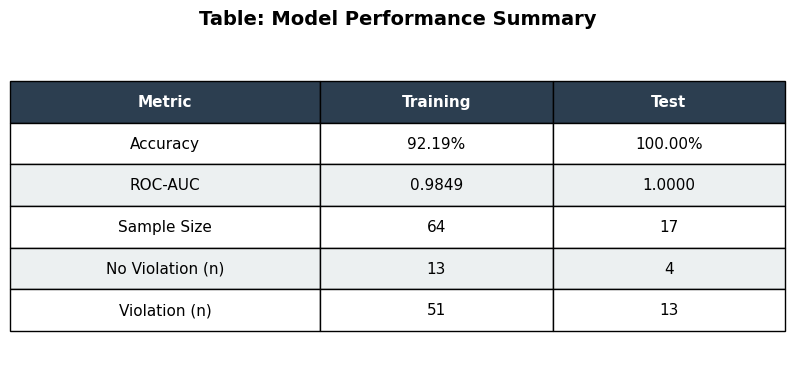

In [30]:
y_train_proba = log_reg.predict_proba(X_train_scaled)[:, 1]
y_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

train_0 = (y_train == 0).sum()
train_1 = (y_train == 1).sum()
test_0 = (y_test == 0).sum()
test_1 = (y_test == 1).sum()

perf_data = [
    ['Metric', 'Training', 'Test'],
    ['Accuracy', f'{train_acc*100:.2f}%', f'{test_acc*100:.2f}%'],
    ['ROC-AUC', f'{train_auc:.4f}', f'{test_auc:.4f}'],
    ['Sample Size', f'{len(y_train)}', f'{len(y_test)}'],
    ['No Violation (n)', f'{train_0}', f'{test_0}'],
    ['Violation (n)', f'{train_1}', f'{test_1}']
]

fig_t5, ax_t5 = plt.subplots(figsize=(10, 4))
ax_t5.axis('tight')
ax_t5.axis('off')

tbl5 = ax_t5.table(cellText=perf_data, cellLoc='center', loc='center',
                   colWidths=[0.4, 0.3, 0.3])
tbl5.auto_set_font_size(False)
tbl5.set_fontsize(11)
tbl5.scale(1, 2.5)

for j in range(3):
    cell = tbl5[(0, j)]
    cell.set_facecolor('#2c3e50')
    cell.set_text_props(weight='bold', color='white')

for i in range(1, len(perf_data)):
    for j in range(3):
        cell = tbl5[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#ecf0f1')
        else:
            cell.set_facecolor('#ffffff')

plt.title('Table: Model Performance Summary', 
          fontsize=14, fontweight='bold', pad=20)
plt.show()

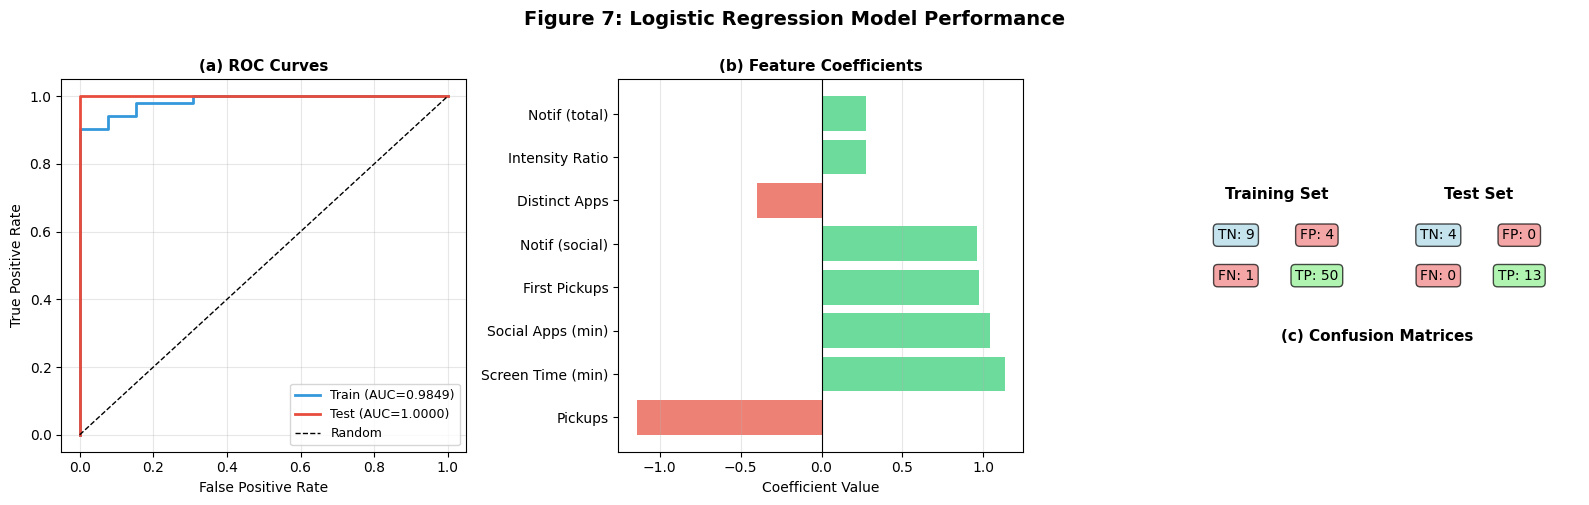


Confusion Matrix (Training):
[[ 9  4]
 [ 1 50]]

Confusion Matrix (Test):
[[ 4  0]
 [ 0 13]]


In [31]:
fig = plt.figure(figsize=(16, 5))

ax1 = plt.subplot(1, 3, 1)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

ax1.plot(fpr_train, tpr_train, label=f'Train (AUC={train_auc:.4f})', linewidth=2, color='#3498db')
ax1.plot(fpr_test, tpr_test, label=f'Test (AUC={test_auc:.4f})', linewidth=2, color='#e74c3c')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax1.set_xlabel('False Positive Rate', fontsize=10)
ax1.set_ylabel('True Positive Rate', fontsize=10)
ax1.set_title('(a) ROC Curves', fontsize=11, fontweight='bold')
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(alpha=0.3)

ax2 = plt.subplot(1, 3, 2)
short_feat = [short_names[independent_vars.index(f)] for f in coef_sorted['Feature']]
coef_colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in coef_sorted['Coefficient']]
bars = ax2.barh(short_feat, coef_sorted['Coefficient'], color=coef_colors, alpha=0.7)
ax2.set_xlabel('Coefficient Value', fontsize=10)
ax2.set_title('(b) Feature Coefficients', fontsize=11, fontweight='bold')
ax2.axvline(0, color='black', linewidth=0.8)
ax2.grid(axis='x', alpha=0.3)

ax3 = plt.subplot(1, 3, 3)
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

cm_combined = np.hstack([cm_train, np.array([[np.nan, np.nan], [np.nan, np.nan]]), cm_test])
im = ax3.imshow([[0, 0]], cmap='Blues', alpha=0)  
ax3.axis('off')
ax3.text(0.25, 0.85, 'Training Set', ha='center', va='center', fontsize=11, fontweight='bold', transform=ax3.transAxes)
ax3.text(0.75, 0.85, 'Test Set', ha='center', va='center', fontsize=11, fontweight='bold', transform=ax3.transAxes)

ax3.text(0.15, 0.65, f'TN: {cm_train[0,0]}', ha='center', va='center', fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7), transform=ax3.transAxes)
ax3.text(0.35, 0.65, f'FP: {cm_train[0,1]}', ha='center', va='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7), transform=ax3.transAxes)
ax3.text(0.15, 0.45, f'FN: {cm_train[1,0]}', ha='center', va='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7), transform=ax3.transAxes)
ax3.text(0.35, 0.45, f'TP: {cm_train[1,1]}', ha='center', va='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7), transform=ax3.transAxes)

ax3.text(0.65, 0.65, f'TN: {cm_test[0,0]}', ha='center', va='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7), transform=ax3.transAxes)
ax3.text(0.85, 0.65, f'FP: {cm_test[0,1]}', ha='center', va='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7), transform=ax3.transAxes)
ax3.text(0.65, 0.45, f'FN: {cm_test[1,0]}', ha='center', va='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7), transform=ax3.transAxes)
ax3.text(0.85, 0.45, f'TP: {cm_test[1,1]}', ha='center', va='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7), transform=ax3.transAxes)

ax3.text(0.5, 0.15, '(c) Confusion Matrices', ha='center', va='center', 
         fontsize=11, fontweight='bold', transform=ax3.transAxes)

plt.suptitle('Figure 7: Logistic Regression Model Performance', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix (Training):")
print(cm_train)
print("\nConfusion Matrix (Test):")
print(cm_test)